## Classification with NN

In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras

# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# custom imports
from transform_fcts import (
    calculate_modular_features,
    binary_features,
    prime_distribution_features,
)


In [2]:
# params
prime_lim = 500000

# read in prime numbers
primes = np.load(f'../../artifacts/primes/prime_{prime_lim}.npy')

# convert to natural numbers with binary target
natural_numbers = np.arange(0,prime_lim)
target = np.zeros(prime_lim, dtype=bool)
target[primes] = True

# create dataframe for features and target
data = pd.DataFrame(data={'n': natural_numbers[2:], 'y': target[2:]})
data = data[data['n']<prime_lim]
data.head()

,n,y
0,2,True
1,3,True
2,4,False
3,5,True
4,6,False


#### Functions for Training & Testing the model

In [3]:
def train_model(model, X_train, X_test, y_train, y_test, epochs, batch_size):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy', 
        metrics=['f1_score']
    )

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    model.evaluate(X_test, y_test, verbose=1)

    return model

def predict(model, X_test):
    return model.predict(X_test)


def binarize_prediction(y_test, y_pred, threshold = None):

    if not threshold:
        thresholds = np.arange(0.0, 1.0, 0.01)  # Test thresholds between 0 and 1
        
        best_f1 = 0
        # Iterate through different thresholds to find the best one
        for threshold in thresholds:
            # Convert probabilities to binary predictions
            y_pred_bin = (y_pred >= threshold).astype(int)
            
            # Calculate F1 score
            f1 = f1_score(y_test, y_pred_bin)
                
            # Check if this threshold gives a better F1 score
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        return (y_pred >= best_threshold).astype(int), threshold

    else:
        return (y_pred >= threshold).astype(int), threshold

### Classification with modular neighbours and binary features

#### Feature Creation

In [3]:
n_modular_features = 5 # not all features
target_col = 'y'

##### modular features #####

# create modular features in helper df
mod_feature_df = calculate_modular_features(data, 0, primes=primes, n_modular_features=n_modular_features)

In [4]:
# modular features of neighbours of n
n_neighbours = 7

for n_dist in range(1, n_neighbours+1):
    data = calculate_modular_features(data_df=data, n_distance=n_dist, mod_df=mod_feature_df)
    data = calculate_modular_features(data_df=data, n_distance=-n_dist, mod_df=mod_feature_df)

data = data.iloc[:-n_neighbours]

In [5]:
modular_features = [feature_name for feature_name in data.columns if 'mod' in feature_name]
data['any_mod'] = data[modular_features].sum(axis=1)>0

In [6]:
# features of binary representation
data = binary_features(data)

# prime distribution features
data = prime_distribution_features(data, primes)

Calculating number of primes < n
Calculating distance to last prime
Calculating distance between to last 2 primes


In [7]:
# split between feature & target column
feature_col = data.columns.drop(target_col).tolist()
print(target_col in feature_col)
print(len(feature_col))

# normalize feature columns
scaler = MinMaxScaler()
data[feature_col] = scaler.fit_transform(data[feature_col])

# split in train & test    
X, y = data[feature_col], data[target_col]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)

False
94


#### Network experiments

In [9]:
epochs=60
batch_size=400

model = keras.models.Sequential()
model.add(keras.Input(shape=(len(feature_col),))),
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.LayerNormalization(axis=1))  
model.add(keras.layers.Dense(64, activation='relu'))  # Hidden layer
model.add(keras.layers.Dense(32, activation='relu'))  # Hidden layer
model.add(keras.layers.Dense(16, activation='relu'))  # Hidden layer
model.add(keras.layers.Dense(1, activation='sigmoid'))


mymodel = train_model(model, X_train, X_test, y_train, y_test, epochs, batch_size)

y_pred, best_threshold = binarize_prediction(y_test, predict(model, X_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

Epoch 1/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.1539 - loss: 0.1763
Epoch 2/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1589 - loss: 0.1399
Epoch 3/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1589 - loss: 0.1398
Epoch 4/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1933 - loss: 0.1395
Epoch 5/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1810 - loss: 0.1398
Epoch 6/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2879 - loss: 0.1390
Epoch 7/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2678 - loss: 0.1394
Epoch 8/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2827 - loss: 0.1394
Epoch 9/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2820 - loss: 0.1387
Epoch 10/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.3321 - loss: 0.1384
Epoch 11/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.3601 - loss: 0.1386
Epoch 12/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

---> NN performs much better, even if we use the same features & settings as in logistic regression <br>
---> we have a worse precision, but an overall much better performance on the recall 

#### Permutation importance - how important are modular neighbour features vs binary features?

In [10]:
_, f1_reference = model.evaluate(X_test, y_test, verbose=1)


5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 496us/step - f1_score: 0.5628 - loss: 0.1848


In [11]:
f1_dif = []

for i in range(len(X_test.columns)):

    
    X_test_shuffled = X_test.copy()
    X_test_shuffled.iloc[:,i] = np.random.permutation(X_test.iloc[:,i].values)
    
    _, f1_shuffled = model.evaluate(X_test_shuffled, y_test, verbose=1)

    f1_dif.append(f1_reference - f1_shuffled)

    if i % 20 == 0:
        print(i)



5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 648us/step - f1_score: 0.5631 - loss: 0.1773
0
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 566us/step - f1_score: 0.5633 - loss: 0.1855
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 569us/step - f1_score: 0.5631 - loss: 0.1842
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 567us/step - f1_score: 0.5625 - loss: 0.1845
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 576us/step - f1_score: 0.5624 - loss: 0.1825
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 541us/step - f1_score: 0.5265 - loss: 0.4411
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 545us/step - f1_score: 0.5583 - loss: 0.1848
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 551us/step - f1_score: 0.5631 - loss: 0.1839
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 527us/step - f1_score: 0.5631 - loss: 0.1834
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 518us/step - f1_score: 0.5623 - loss: 0.1839
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 545us/step - f1_score: 0.5277 - loss: 0.4353
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 545us/step - f1_score: 0.5646 - loss: 0.2122
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 3s 530us/step - f1_

In [12]:
permutation_importance = pd.DataFrame(columns=['Features', 'Permutation Importance'], data=np.array([X_test.columns, f1_dif]).T)

In [13]:
permutation_importance.sort_values('Permutation Importance', inplace=True)

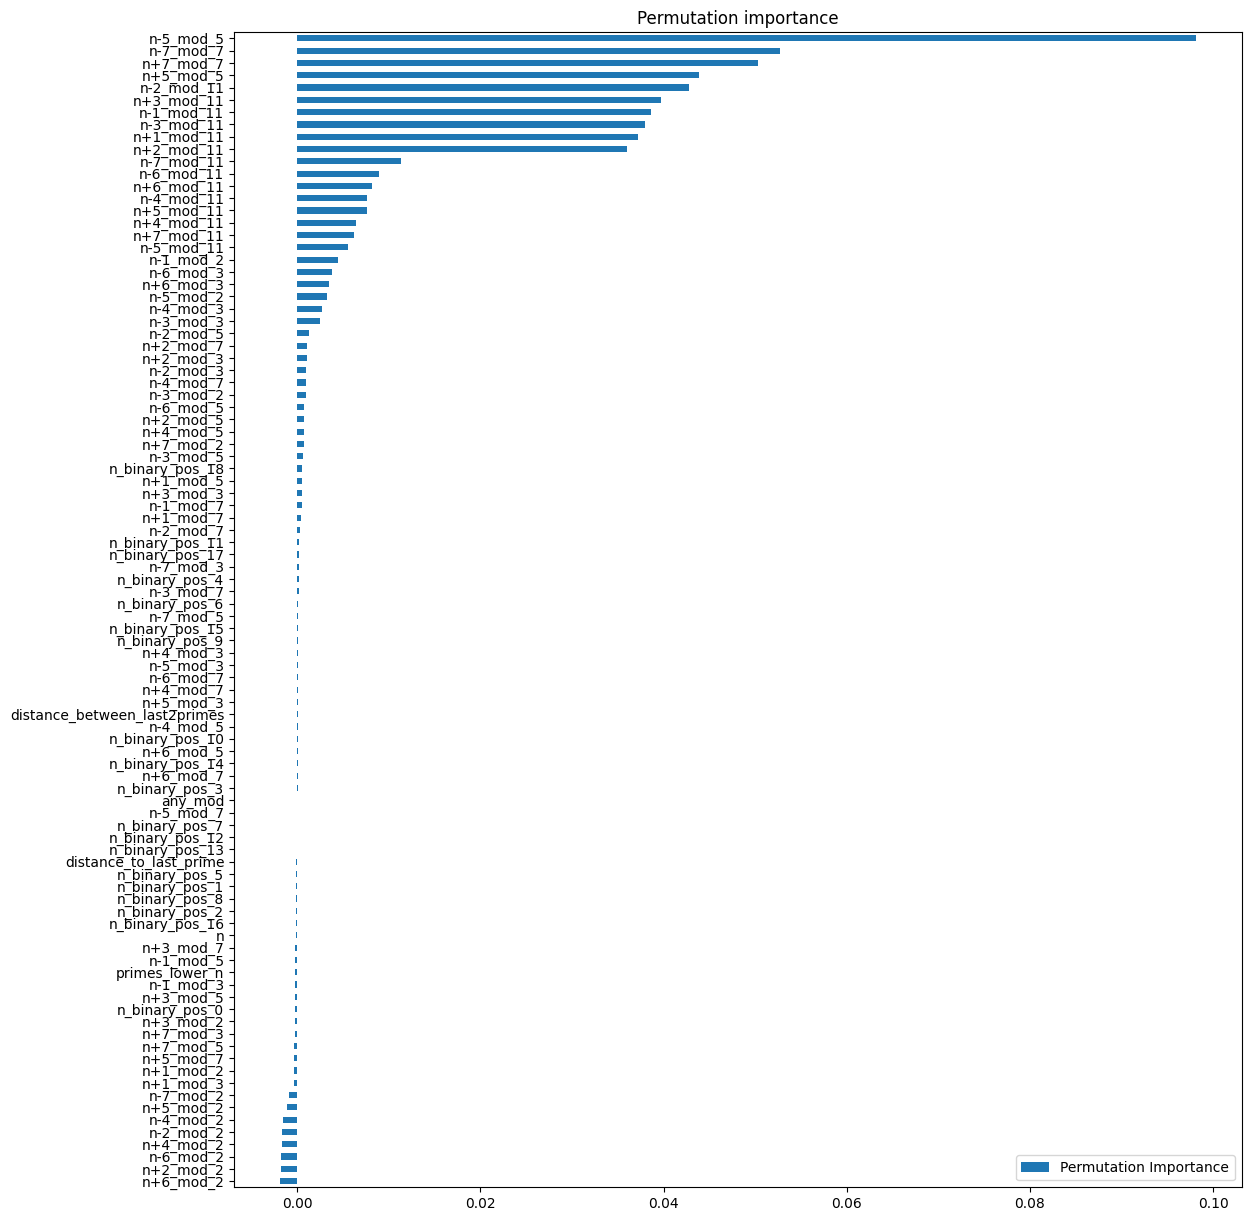

In [14]:
fig, ax = plt.subplots(1,1, figsize=(13,15))

permutation_importance.plot(x='Features', y='Permutation Importance', kind='barh', ax=ax, title='Permutation importance')

ax.yaxis.label.set_visible(False)

plt.subplots_adjust(wspace=0.7)

In [ ]:
# binary position 18 is the one which shows whether a number is dividable by 2
# as well as the modular features n+1/2, n-1/2, ...

### Classification with only binary features

In [4]:
target_col = 'y'

# features of binary representation
data = binary_features(data)

# prime distribution features
data = prime_distribution_features(data, primes)

# split between feature & target column
feature_col = data.columns.drop(target_col).tolist()
print(target_col in feature_col)
print(len(feature_col))

# normalize feature columns
scaler = MinMaxScaler()
data[feature_col] = scaler.fit_transform(data[feature_col])

# split in train & test    
X, y = data[feature_col], data[target_col]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=42)

Calculating number of primes < n
Calculating distance to last prime
Calculating distance between to last 2 primes
False
23


In [5]:
epochs=60
batch_size=400

model = keras.models.Sequential()
model.add(keras.Input(shape=(len(feature_col),))),
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.LayerNormalization(axis=1))  
model.add(keras.layers.Dense(64, activation='relu'))  # Hidden layer
model.add(keras.layers.Dense(32, activation='relu'))  # Hidden layer
model.add(keras.layers.Dense(16, activation='relu'))  # Hidden layer
model.add(keras.layers.Dense(1, activation='sigmoid'))


mymodel = train_model(model, X_train, X_test, y_train, y_test, epochs, batch_size)

y_pred, best_threshold = binarize_prediction(y_test, predict(model, X_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

Epoch 1/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.1534 - loss: 0.2510
Epoch 2/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1540 - loss: 0.2250
Epoch 3/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1532 - loss: 0.2238
Epoch 4/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1553 - loss: 0.2222
Epoch 5/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1617 - loss: 0.2231
Epoch 6/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.1792 - loss: 0.2236
Epoch 7/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2134 - loss: 0.2240
Epoch 8/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2148 - loss: 0.2217
Epoch 9/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2548 - loss: 0.2217
Epoch 10/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2642 - loss: 0.2221
Epoch 11/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2552 - loss: 0.2222
Epoch 12/60
838/838 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step